In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from functools import partial

%matplotlib inline

In [2]:
import logging
logging.basicConfig(level=logging.CRITICAL)
import warnings
warnings.simplefilter("ignore") # ignore plotting warnings

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

# ELFI - Engine for Likelihood-Free Inference


European Meeting of Statisticians
July 25th, 2017

Antti Kangasrääsiö
Aalto University, Probabilistic Machine Learning Research Group

Joint work with:
Jarno Lintusaari (Aalto), Henri Vuollekoski (Aalto), Kusti Skytén (Aalto), Marko Järvenpää (Aalto), Michael Gutmann (University of Edinburgh), Aki Vehtari (Aalto), Jukka Corander (University of Oslo), Samuel Kaski (Aalto)

## Example: the 2nd order Moving Average model (MA2)

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2}
$$

In [4]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    t1 = np.atleast_2d(t1).reshape(-1,1)
    t2 = np.atleast_2d(t2).reshape(-1,1)
    w = random_state.randn(batch_size, n_obs+2)
    y = w[:, 2:] + (t1 * w[:, 1:-1]) + (t2 * w[:, :-2])
    return y 

### Generate some "observed" data:

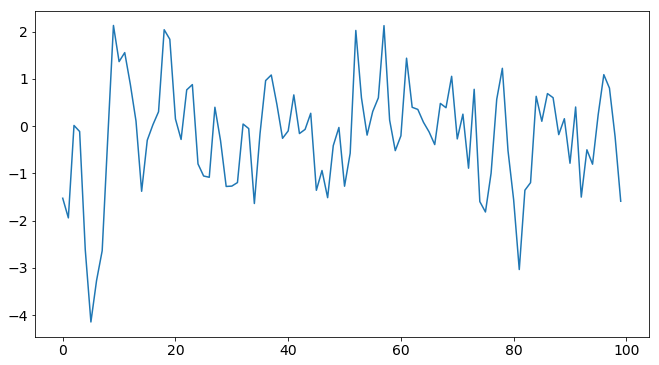

In [5]:
# true parameters
t1_true = 0.6
t2_true = 0.2

# Set up observed data y with some random seed
rs = np.random.RandomState(25072017)
y_obs = MA2(t1_true, t2_true, random_state=rs)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());

### To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:

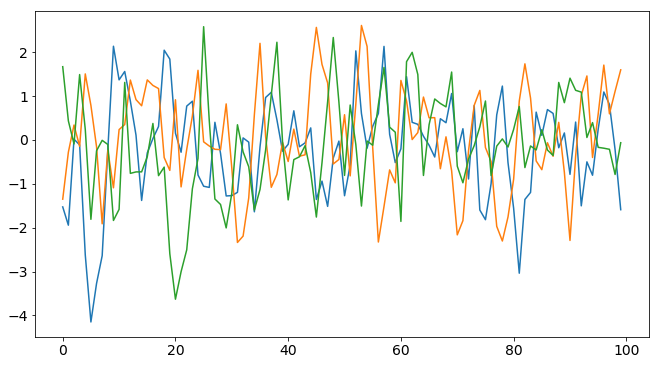

In [6]:
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());
plt.plot(MA2(t1_true, t2_true, random_state=rs).flatten());
plt.plot(MA2(t1_true, t2_true, random_state=rs).flatten());

### How can you compare these?

### Comparing noisy data

Calculate the discrepancy (distance) between some summary statistics, like the first two autocovariances:

In [7]:
def autocov(x, lag=1):
    mu = np.mean(x, axis=1, keepdims=True)
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True) - mu**2.
    return C

def distance(*simulated, observed):
    d = np.linalg.norm(np.array(simulated) - np.array(observed),
                       ord=2, axis=0)
    return d

And then what?

In [8]:
import elfi

## Using ELFI to infer the parameters

In [9]:
elfi.new_model()
t1 = elfi.Prior(scipy.stats.uniform, 0, 2, name="t1")
t2 = elfi.Prior('uniform', 0, 2, name="t2")

In [10]:
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

In [11]:
S1 = elfi.Summary(autocov, Y, name="S1")

autocov2 = partial(autocov, lag=2)
S2 = elfi.Summary(autocov2, Y, name="S2")

In [12]:
d = elfi.Discrepancy(distance, S1, S2, name="d")

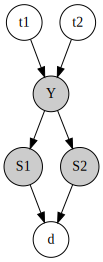

In [13]:
elfi.draw(d)

### To demonstrate customizability, let's change the prior

In [14]:
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size,
                                    random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)
        return p

class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, 
                                     random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)
        return p

### These priors sample from a triangle

$-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$

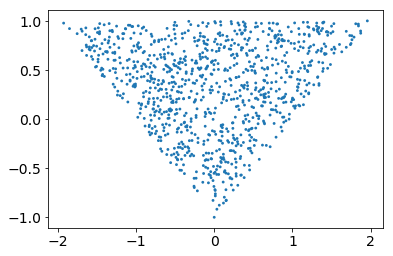

In [15]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=8, edgecolor='none');

### Redefine the model with these priors

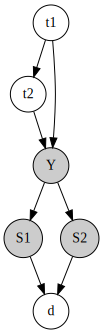

In [16]:
elfi.new_model()

t1 = elfi.Prior(CustomPrior_t1, 2)
t2 = elfi.Prior(CustomPrior_t2, t1, 1)
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov2, Y)
d = elfi.Discrepancy(distance, S1, S2)

elfi.draw(d)

### Now we just sample *a lot* to get an approximate posterior

In [17]:
# make sure we have the native client
from elfi.clients.native import set_as_default
set_as_default()

In [18]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

%time result = rej.sample(1000, n_sim=1e6)

CPU times: user 5.53 s, sys: 1.03 s, total: 6.55 s
Wall time: 7.33 s


In [19]:
result.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0367
Sample means: t1: 0.666, t2: 0.233


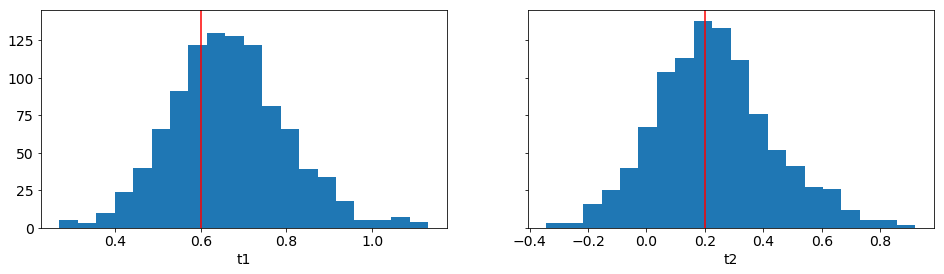

In [20]:
ax = result.plot_marginals();
ax[0].axvline(t1_true, color='r');
ax[1].axvline(t2_true, color='r');

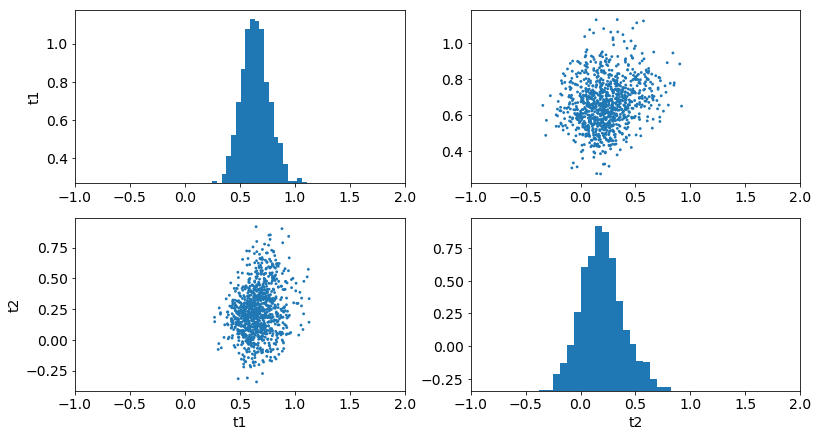

In [21]:
# Setup the figure axis limits
ax = plt.subplots(2,2, figsize=(13,7), subplot_kw={'xlim':[-1,2]})[1]

# Plot
result.plot_pairs(s=8, axes=ax);

## Let's do that in parallel!

Currently ELFI supports the powerful *ipyparallel* library for parallel and distributed computing.

In [22]:
from elfi.clients.multiprocessing import set_as_default
set_as_default()

In [23]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

%time result_parallel = rej.sample(1000, n_sim=1e6)

CPU times: user 249 ms, sys: 22.1 ms, total: 271 ms
Wall time: 3.47 s


In [24]:
result_parallel.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0362
Sample means: t1: 0.658, t2: 0.244


## Sequential Monte Carlo ABC (Importance sampling)

In [25]:
smc = elfi.SMC(d, [t1, t2], batch_size=10000)

schedule = [0.7, 0.2, 0.05]

%time result_smc = smc.sample(1000, schedule)

CPU times: user 498 ms, sys: 21.4 ms, total: 519 ms
Wall time: 1.01 s


In [26]:
result_smc.summary()

Method: SMC
Number of samples: 1000
Number of simulations: 130000
Threshold: 0.0494
Sample means: t1: 0.655, t2: 0.236


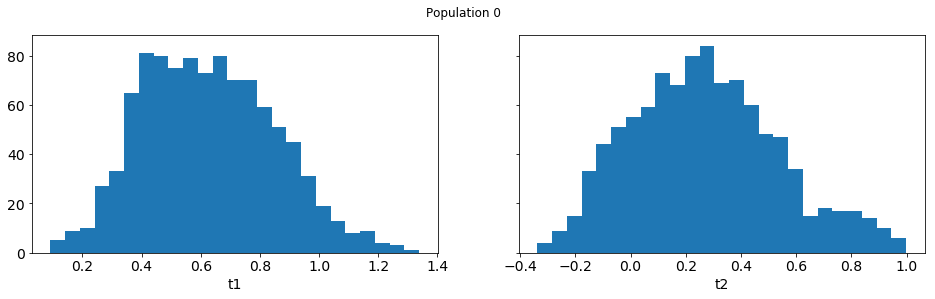

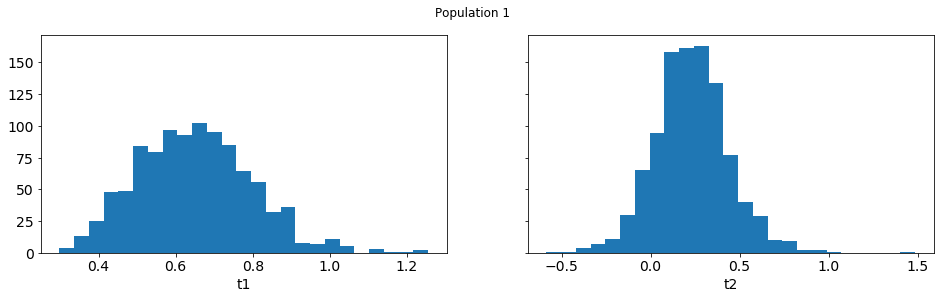

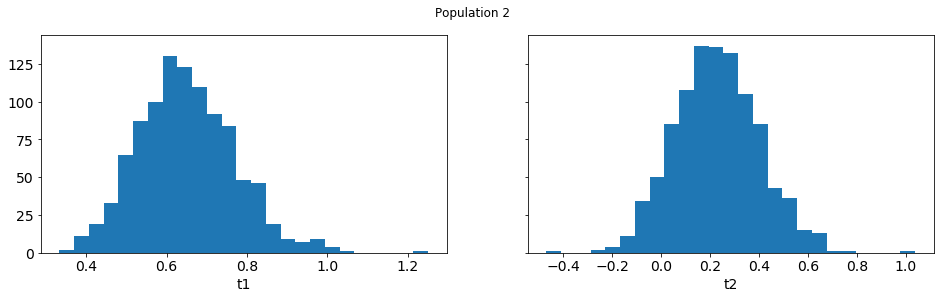

In [27]:
result_smc.plot_marginals(all=True, bins=25, figsize=(1, 1), fontsize=12)

## BOLFI (Bayesian Optimization for Likelihood-Free Inference)

In [28]:
log_d = elfi.Operation(np.log, d)

In [29]:
bolfi = elfi.BOLFI(log_d, initial_evidence=20, update_interval=10, 
                   bounds={'t1':(-2, 2), 't2':(-1, 1)}, acq_noise_var=[0.01, 0.01], seed=2017)
%time post = bolfi.fit(n_evidence=100)

CPU times: user 12.2 s, sys: 348 ms, total: 12.6 s
Wall time: 13.2 s


### ELFI currently uses GPy for Gaussian processes

In [30]:
bolfi.target_model


Name : GP regression
Objective : 85.09593354410278
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |     priors    
  sum.rbf.variance         |    0.3346454654  |      +ve      |  Ga(0.028, 1) 
  sum.rbf.lengthscale      |  0.570114342077  |      +ve      |   Ga(1.3, 1)  
  sum.bias.variance        |  0.118159179926  |      +ve      |  Ga(0.0069, 1)
  Gaussian_noise.variance  |  0.172060403501  |      +ve      |               

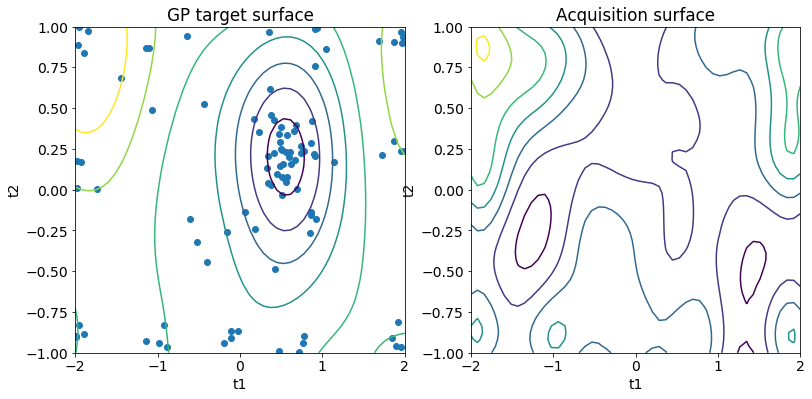

In [31]:
bolfi.plot_state()

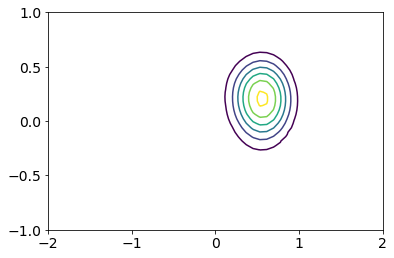

In [32]:
post.plot(logpdf=False)

In [33]:
# NUTS sampling
%time result_bolfi = bolfi.sample(250)

4 chains of 250 iterations acquired. Effective sample size and Rhat for each parameter:
t1 642.70656716 0.999328943063
t2 315.064476192 1.01383514713
CPU times: user 345 ms, sys: 13.7 ms, total: 358 ms
Wall time: 9.32 s


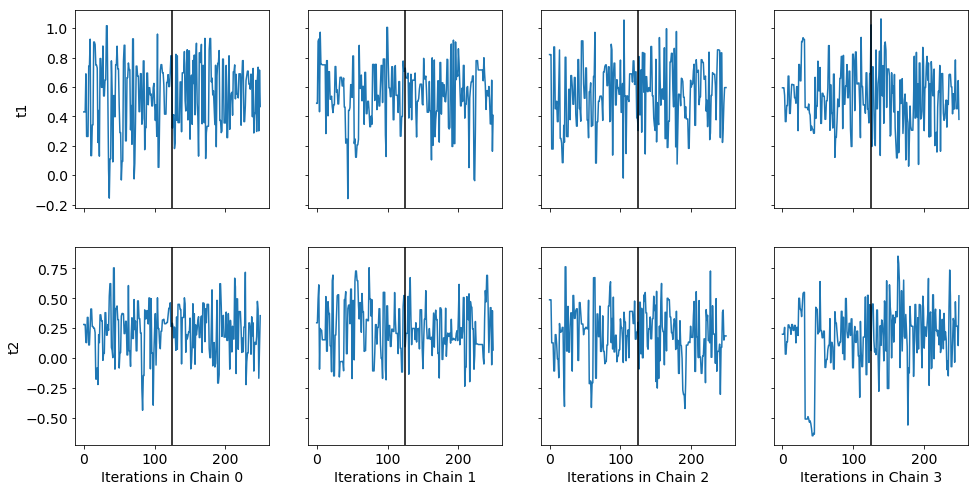

In [34]:
result_bolfi.plot_traces();

In [35]:
result_bolfi.summary()

Method: BOLFI
Number of samples: 500
Number of simulations: 100
Threshold: -1.4
Sample means: t1: 0.548, t2: 0.216
